In [354]:
import gym_duckietown
import matplotlib.pyplot as plt
import numpy as np

from gym_duckietown.simulator import Simulator
from casadi import *

from utils import get_trajectory, get_position

In [355]:
# Hyperparameters
test_results = True
T = 15
N = 20
n_from_index = 2 # How distant the first point is

In [356]:
plt.rcParams['figure.figsize'] = [7, 7]

In [357]:
#gym_duckietown is very chatty
import logging
gym_duckietown.logger.setLevel(logging.WARNING)

In [358]:
env = Simulator("small_loop",
    full_transparency=True,
    domain_rand=False,
    user_tile_start=[1,0],
    seed=42,
    max_steps=float("inf"),
)

In [359]:
env.unwrapped.start_pose = [[0.11699990272521976, 0, 0.41029359288296474], 0]

In [360]:
env.reset()
traj = get_trajectory(env, samples=200)

/home/giulio/prog/duckrace_simulator/utils.py:235: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  points_fitted = np.vstack( spl(alpha) for spl in splines ).T


In [361]:
pose = get_position(env)
pose

Position(x=0.7019999027252197, y=1.3447064071170352, theta=0)

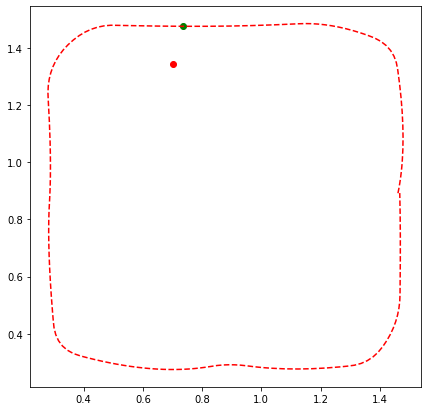

In [362]:
from scipy import spatial
distance,index = spatial.KDTree(traj).query([pose.x, pose.y])
index -= n_from_index
plt.plot(*traj.T, "r--")
plt.scatter(pose.x, pose.y, c="r")
plt.scatter(traj[index,0], traj[index,1], c="g")

In [363]:
# Compute the angle between every consecutive points in traj
angles = np.zeros(traj.shape[0])
for i in range(traj.shape[0]-1):
    angles[i] = np.arctan2(traj[i+1,1]-traj[i,1], traj[i+1,0]-traj[i,0])
angles[-1] = np.arctan2(traj[0,1]-traj[-1,1], traj[0,0]-traj[-1,0])
angles = np.pi - angles
angles = np.where(angles<0, angles+2*np.pi, angles)

In [364]:
# Add angles to traj
traj = np.concatenate((traj, angles.reshape(-1,1)), axis=1)

In [365]:
index = DM(index)
traj = DM(traj)

Initialize states, inputs, and system dynamic equation

In [366]:
dt = 1.0 / env.frame_rate

In [367]:
up = 5
wp = 4
# parameters for forced dynamics
u_alpha_r = 1.5
u_alpha_l = 1.5
w_alpha_r = 15  # modify this for trim
w_alpha_l = 15

In [368]:
pose = get_position(env)

DAE

In [369]:
# States
x0 = MX.sym('x')
y0 = MX.sym('y')
th0 = MX.sym('th')
v0 = MX.sym('v')
w0 = MX.sym('w')
x = vertcat(x0, y0, th0, v0, w0) # Always vertically concatenate the states --> [n_x,1]
# Inputs
wl = MX.sym('wl')
wr = MX.sym('wr')
u = vertcat(wl, wr) # Always vertically concatenate the inputs --> [n_u,1]
# System dynamics (CAN BE NONLINEAR! ;))
# x_long_dot_dot = -u1*v0 + u_alpha_r*wr + u_alpha_l*wl
# w_dot_dot = -w1*w0 + w_alpha_r*wr - w_alpha_l*wl
v1 = (1-up*dt)*v0 + u_alpha_r*dt*wr + u_alpha_l*dt*wl
w1 = (1-wp*dt)*w0 + w_alpha_r*dt*wr - w_alpha_l*dt*wl
x1 = x0 + v0*dt*np.cos(th0 + w0*dt/2)
y1 = y0 + v0*dt*np.sin(th0 + w0*dt/2)
theta1 = th0 + w0*dt
dae = vertcat(x1, y1, theta1, v1, w1)
F = Function('F',[x,u],[dae],['x','u'],['dae'])
if test_results:
    print(F([pose.x, pose.y, pose.theta, 0, 0], [1, 1]))

[0.70199990272522, 1.34470640711704, 0, 0.1, 0]


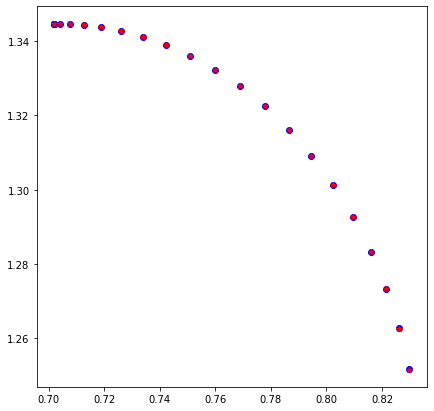

In [370]:
N_test=20
# Test the problem definition
sim = F.mapaccum(N_test) # To call the F function N times
x0 = [pose.x, pose.y, pose.theta, 0, 0]

res = sim(x0, [1, 0.2])
fig = plt.figure()
tgrid = np.linspace(0,T,N)
# plt.plot(tgrid, np.column_stack((x0, res)).T)
plt.plot(res[0, :], res[1, :], 'r*')
env.reset()
for action in [[1, 0.2]]*(N_test+3):
    obs, reward, done, info = env.step(action)
    p = get_position(env)
    plt.scatter(p.x, p.y, c='b')
_ = env.reset()

In [371]:
delay = round(0.15/dt)
u_delay0 = DM(np.zeros((2, delay)))
N += delay

# Initial reference point
r0 = repmat(traj[index, :2].T, 1, N+1)
# Initial reference angles
t0 = repmat(traj[index, 2].T, 1, N+1)

In [402]:
opti = Opti() # Special CasADi stack for optimization

x = opti.variable(5,N+1)    # States with dimension (n_x, prediction_horizon+1) (x(0),...,x(N+1))
u = opti.variable(2,N-delay)      # Inputs with dimension (n_u, prediction_horizon) (u(0),...,u(N))
p = opti.parameter(5,1)     # Parameter to set the initial state conditions (x(0))
r = opti.parameter(2,N+1)   # Parameter to set the initial index
tr = opti.parameter(1,N+1)   # Parameter to set the initial reference angles
u_delay = opti.parameter(2,delay) # Parameter to set the delay

Q, Q2, R = 1, 1e-4, 1e-3
obj = Q*sumsqr(x[:2, :]-r) + Q2*sumsqr(x[2, :] - tr) + R*sumsqr(u)   # Objective function: (NOT NECESSARILY quadratic!)

opti.minimize(obj)          # Setup the problem 

# Constraints Definition

# 1) System dynamics constraint over the prediction horizon
for k in range(0,N):
   opti.subject_to(x[:,k+1]==F(x[:,k],horzcat(u_delay, u)[:, k])) # Horzacat to include delay
    
# 2) Additional states/inputs constraints 
opti.subject_to(vec(u) <= 1)
opti.subject_to(vec(u) >= -1)
# 3) Force the state variable at instant 0 to be equal to the parameter value containing x0 value
opti.subject_to(x[:,0] == p)

opti.set_value(p,[pose.x, pose.y, pose.theta, 0, 0]) # Set the initial x0 value
opti.set_value(r,r0) # Set the initial index
opti.set_value(tr,t0) # Set the initial reference angles
opti.set_value(u_delay, u_delay0) # Initial delay

# Ipopt
opts = dict()
opts["ipopt.print_level"] = 0
opts["print_time"] = False
opti.solver('ipopt',opts)

# If you want to test over 1 time horizon
if test_results:
    sol = opti.solve()

In [403]:
# This instruction transfom all the Opti problem defined above into a callable function
M = opti.to_function('M',[p, r, tr, u_delay],[u[:,0]],['p', 'r', 'tr', 'u_delay'],['u_opt'])

In [404]:
# MPC loop
X_log = np.empty((5,0))
U_log = np.empty((2,0))

x = [pose.x, pose.y, pose.theta, 0, 0]
r = r0
tr = t0
idx = index
u_delay = u_delay0

for i in range(300):
    u = M(x, r, tr, u_delay)

    U_log = np.column_stack((U_log, u))
    X_log = np.column_stack((X_log, x))

    u_delay = np.column_stack((u_delay, u))[:, -delay:]

    # simulate
    x = F(x,u)

    if (traj[idx, 0] - x[0])**2 + (traj[idx, 1] - x[1])**2 < 0.001:
        idx = idx-1
        r = repmat(traj[idx, :2].T, 1, N+1)
        tr = repmat(traj[idx, 2].T, 1, N+1)

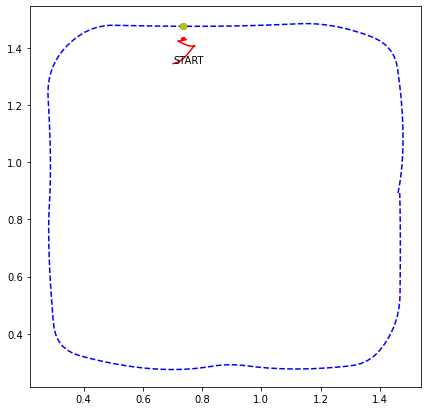

In [405]:
plt.text(X_log[0,0], X_log[1,0], 'START')
plt.plot(traj[:,0], traj[:,1], "b--")
plt.plot(traj[index,0], traj[index,1], 'go')
plt.plot(X_log[0,:], X_log[1,:], "r")
plt.plot(traj[idx, 0], traj[idx,1], 'yo')

If you want to save the MPC controller, i.e. the M function for later use, you can do it!

In [406]:
M.save('M.casadi')
M2 = Function.load('M.casadi')
DM.set_precision(15)
print(M(x0, r0, t0, u_delay0))
print(M2(x0, r0, t0, u_delay0))

[-0.999999616578552, 0.999999913947699]
[-0.999999616578552, 0.999999913947699]


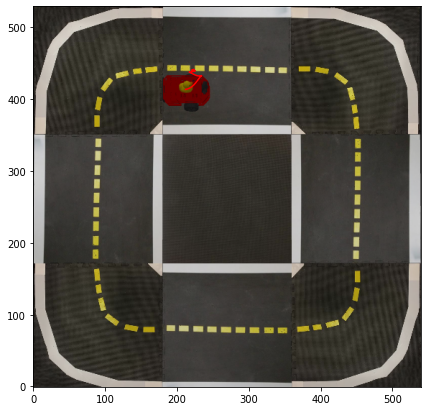

In [407]:
env.reset()
top_view = env.render(mode="top_down")[35:-35,130:-130]
plt.plot([p*top_view.shape[0]/(env.grid_width*env.road_tile_size) for p in X_log[0,:]], [p*top_view.shape[1]/(env.grid_width*env.road_tile_size) for p in X_log[1,:]], c='r')
plt.imshow(top_view, origin='lower')

### Gym simulation

The MPC does not consider the delay yet!

In [408]:
import imageio

env.reset()
images = []
positions = []
for action in U_log.T:
    env.step(action)
    positions.append(get_position(env))
    images.append(env.render(mode="rgb_array"))

imageio.mimsave("assets/mpc_run.gif", images[::2])

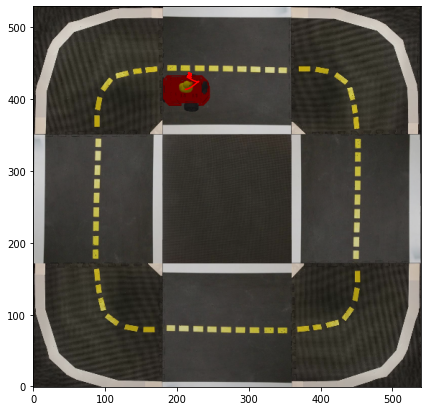

In [ ]:
env.reset()
top_view = env.render(mode="top_down")[35:-35,130:-130]
plt.plot([p.x*top_view.shape[0]/(env.grid_width*env.road_tile_size) for p in positions], [p.y*top_view.shape[1]/(env.grid_width*env.road_tile_size) for p in positions], c='r')
plt.imshow(top_view, origin='lower')

In [ ]:
from IPython.display import HTML, display
# Trick to prevent cache use
display(HTML('<img src="assets/mpc_run.gif?%d" width="750" align="center">' % np.random.randint(10)))